In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Required Libraries**

In [2]:
# Work around to get Matplotlib Fonts and Latex working in Google Colab Environment
# - Restart Runtime After this cell is first executed for changes to take effect
!sudo apt install font-manager

!sudo aptitude install texlive-fonts-recommended texlive-fonts-extra
!sudo apt-get install dvipng
!sudo apt-get install cm-super

! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash

!sudo apt install msttcorefonts -qq
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libgee-0.8-2 libgucharmap-2-90-7
Suggested packages:
  file-roller python-gobject python-nautilus yelp
The following NEW packages will be installed:
  font-manager libgee-0.8-2 libgucharmap-2-90-7
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 1,581 kB of archives.
After this operation, 7,187 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgee-0.8-2 amd64 0.20.1-1 [210 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgucharmap-2-90-7 amd64 1:10.0.4-1 [1,080 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 font-manager amd64 0.7.3-1.1 [291 kB]
Fetched 1,581

In [15]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
import seaborn as sns
from copy import copy, deepcopy
from pickle import dump, load
import sys
import time
sys.path.append('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/utils')
from dimReduction import dim_reduction_PCA, elbowHeuristic_PCA
from kmeans import kmeans, optimalK
from cmeans import cmeans, optimal_fuzzifier, optimal_clusters
from agglomerative import agglomerativeClustering, elbowHeuristic_Agglo
from cviMetrics import compute_cvi, cluster_diameter, intercluster_dist, calc_cluster_centroids_and_radius
from utils import plotClusters, calc_cluster_centroids
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

# **Import Pre-Processed Data**

In [4]:
processedData = load(open('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/data/preProcessed_loadDiagrams3.pkl', 'rb'))
print(processedData.shape)

(315, 96)


# **More Utility Functions**

## Plot TSNE

In [5]:
def plot_TSNE(data, clusterLabels, nClusters, randomSeed=51, figPath=None, perplexity=50, learning_rate=15, legend_loc='lower right'):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=750, init='pca', random_state=randomSeed, method='barnes_hut', learning_rate=learning_rate)
    ProcessedTSNE = tsne.fit_transform(data)
    df_subset = dict()
    df_subset['tsne-2d-one'] = ProcessedTSNE[:,0]
    df_subset['tsne-2d-two'] = ProcessedTSNE[:,1]
    plt.figure(figsize=(16,10))
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('font', size=31)         # controls default text sizes
    plt.rc('axes', titlesize=32)    # fontsize of the axes title
    plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
    plt.rc('legend', fontsize=31)   # legend fontsize
    plt.rc('figure', titlesize=32)  # fontsize of the figure title
    tsne_plot = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                                hue=clusterLabels,
                                palette=sns.color_palette("tab10", nClusters),
                                data=df_subset,
                                #legend=False,
                                legend="full",
                                alpha=0.8)
    tsne_plot.legend(loc=legend_loc,ncol=2, title="Cluster ID")

    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    plt.xlim([np.min(ProcessedTSNE[:,0]-0.2), np.max(ProcessedTSNE[:,0])+0.7])
    plt.ylim([np.min(ProcessedTSNE[:,1]-0.2), np.max(ProcessedTSNE[:,1])+0.2])
    if figPath is not None:
        plt.savefig(figPath, bbox_inches = 'tight', pad_inches = 0.05)
        plt.close()

## Plot CVI Comparison (Bar Graph)

In [6]:
def plotCVIcomparison(scores1, label1, scores2, label2, metrics, chScore1=None, chScore2=None, chIndex=None, figPath=None):
    if chIndex is not None:
        chScore1 = scores1[chIndex]
        chScore2 = scores2[chIndex]
        scores1 = scores1[0:chIndex] + scores1[chIndex+1:]
        scores2 = scores2[0:chIndex] + scores2[chIndex+1:]
        chMetric = metrics[chIndex]
        metrics = metrics[0:chIndex] + metrics[chIndex+1:]
    df = pd.DataFrame({label1: scores1, label2: scores2}, index=metrics)
    if (chScore1 is not None) and (chScore2 is not None):
        df2 = pd.DataFrame({label1: [chScore1], label2: [chScore2]}, index=[chMetric])
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['text.usetex'] = True
    plt.rc('font', size=21)         # controls default text sizes
    plt.rc('axes', titlesize=22)    # fontsize of the axes title
    plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=19)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=19)   # fontsize of the tick labels
    plt.rc('legend', fontsize=21)   # legend fontsize
    plt.rc('figure', titlesize=22)  # fontsize of the figure title
    
    if (chScore1 is not None) and (chScore2 is not None):
        figure, axes = plt.subplots(1, 2, figsize=(15,6), gridspec_kw={'width_ratios': [len(scores1), 1]})
        df.plot.bar(rot=0, ax=axes[0], legend=None)
        axes[0].set_ylabel("CVI Metric Value")
        df2.plot.bar(rot=0, ax=axes[1], legend=None)
        axes[0].legend(ncol=2, bbox_to_anchor=(0.125, 0.675, 1, 0.5), loc='upper left', borderaxespad=0, mode="expand")#(0.625, 1.1)
    else:
        df.plot.bar(rot=0, figsize=(10,6))
        plt.ylabel("CVI Metric Value")
    if figPath is not None:
        plt.savefig(figPath, bbox_inches = 'tight', pad_inches = 0.05)
        plt.close()

In [7]:
def plotCVIcomparisonSeparate(scores1, label1, scores2, label2, metrics, figPath=None):
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['text.usetex'] = True
    plt.rc('font', size=24)         # controls default text sizes
    plt.rc('axes', titlesize=25)    # fontsize of the axes title
    plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=22)   # fontsize of the tick labels
    plt.rc('ytick', labelsize=22)   # fontsize of the tick labels
    plt.rc('legend', fontsize=24)   # legend fontsize
    plt.rc('figure', titlesize=25)  # fontsize of the figure title

    figure, axes = plt.subplots(1, len(metrics), figsize=(15,6), gridspec_kw={'width_ratios': [1]*len(metrics)})
    figure.tight_layout(pad=0.5)
    for i in range(len(metrics)):
        tempdf = pd.DataFrame({label1: scores1[i], label2: scores2[i]}, index=[metrics[i]])
        #tempdf.plot.bar(rot=0, ax=axes[i], legend=None)
        tempdf.plot(kind='bar', width=0.5, rot=0, ax=axes[i], legend=None, color=['#1e8271', '#f6b4b4'])
        axes[i].set_ylim((0.9*min(scores1[i],scores2[i]), 1.05*max(scores1[i],scores2[i])))
        axes[0].set_ylabel("CVI Metric Value")
        axes[0].legend(ncol=2, bbox_to_anchor=(0.6, 0.675, 5, 0.5), loc='upper left', borderaxespad=0, mode="expand")#(0.625, 1.1)
    if figPath is not None:
        plt.savefig(figPath, bbox_inches = 'tight', pad_inches = 0.05)
        plt.close()

## Make Cluster List

In [8]:
'''
Making Cluster arrays
'''
def makeClusterList(nCluster, labels, data):
    clusterList = []
    for clusterID in range(nCluster):
        temp = np.zeros((len(labels[labels==clusterID]), data.shape[1]))
        counter = 0
        for houseIdx, houseLabel in enumerate(labels):
            if houseLabel==clusterID:
                temp[counter, :] = data[houseIdx, :]
                counter += 1
        clusterList.append(temp)
    return clusterList

# **Start with Clustering Framework**

Dimensionality Reduction

In [9]:
plt.rcParams["font.family"] = "Times New Roman"
#CEVR, nComponents = 
elbowHeuristic_PCA(processedData, random_state=56, markX=0.9617396747826681, markY=10, annotX=0.65, annotY=35,# debug = True)
                   figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/ElbowHeuristic_PCA.pdf')
day_median_consumption_reducedPCA, nComponents = dim_reduction_PCA(processedData, 0.961, random_state=56)
print(nComponents)
#for i in range(len(nComponents)):
#    print(nComponents[i], ' - ', CEVR[i])

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


10


Clustering Algorithm

In [10]:
fuzzifierPCA = optimal_fuzzifier(day_median_consumption_reducedPCA)
print(fuzzifierPCA)

1.291552734375


In [11]:
plt.rcParams["font.family"] = "Times New Roman"
nclustersFCMPCA = optimal_clusters(day_median_consumption_reducedPCA, maxClusters=10, seed=56,
                                   trials=10, fuzzifier = fuzzifierPCA, plotting=True,
                                   figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/FuzzyPartitionCoefficient_PCA_FCM.pdf')
nclustersFCMPCA = 4
print('Optimal Clusters (PCA + Fuzzy C-Means) is: ', nclustersFCMPCA)
fcmResultsPCA = cmeans(day_median_consumption_reducedPCA, nclustersFCMPCA, fuzzifierPCA, error=0.005, maxiter=1000, seed=56)
centersFCMPCA = fcmResultsPCA[0]
fuzzyMemMatPCA = fcmResultsPCA[1]
labelsFCMPCA = np.argmax(fuzzyMemMatPCA, axis=0)

Optimal Clusters (PCA + Fuzzy C-Means) is:  4


In [ ]:
plt.rcParams["font.family"] = "Times New Roman"
#distThr,nClustersACPCA = 
elbowHeuristic_Agglo(day_median_consumption_reducedPCA, markX=0.65, markY=8, annotX=0.75, annotY=20,
                     figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/ElbowHeuristic_PCA_AC.pdf')
#for i in range(len(distThr)):
#    print(nClustersACPCA[i], ' - ', distThr[i])
nclustersACPCA = 8

In [ ]:
acResultsPCA = agglomerativeClustering(day_median_consumption_reducedPCA, n_clusters=nclustersACPCA)
centersACPCA = acResultsPCA[0]
labelsACPCA = acResultsPCA[1]

In [41]:
def calc_WSS(data, cCenters, cLabels):
    """
    Calculate total within-cluster sum of squares (WSS) for each cluster, given
    the cluster centers and the cluster labels. 
    Params:
        data: ndarry of shape (n_samples, n_features)
        cCenters: List[ndarry of shape (n_features,)]
        cLabels: List[n_samples]
                 - categorized as 0,1,2,... for each cluster
    Returns:
        WSS: List[number of clusters]
             - WSS for each cluster
        avgWSS: double
                - Average WSS for all the clusters
    """
    WSS = []
    for i in range(len(cCenters)):
        cluster_center = cCenters[i]
        cluster_pts = []
        for j in range(len(cLabels)):
            if cLabels[j] == i:
                cluster_pts.append(data[j,:])
        wss = np.sqrt(np.mean(np.power(np.abs(np.array(cluster_pts)-cluster_center), 2)))
        WSS.append(wss)
    return WSS, np.mean(np.array(WSS))

plt.rcParams["font.family"] = "Times New Roman"
maxClusters = 10
randomSeed = 51
total_WSS = np.zeros(maxClusters)
for i in range(1,maxClusters):
    kmCenters, kmLabels = kmeans(day_median_consumption_reducedPCA, i, randomSeed)
    _, total_WSS[i] = calc_WSS(day_median_consumption_reducedPCA, kmCenters, kmLabels)
#print(total_WSS)

markX = 6
markY = 0.02747076
annotX = 6.2
annotY = 0.045
figPath = '/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/ElbowMethod_PCA_KMC.pdf'

plt.rc('font', size=21)         # controls default text sizes
plt.rc('axes', titlesize=22)    # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=19)   # fontsize of the tick labels
plt.rc('ytick', labelsize=19)   # fontsize of the tick labels
plt.rc('legend', fontsize=21)   # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.figure(figsize=(10,6))
plt.plot(range(1,maxClusters), total_WSS[1:])
if markX is not None and markY is not None:
    plt.hlines(markY, 0, markX, linestyles='dashed')
    plt.vlines(markX, 0, markY, linestyles='dashed')
    plt.scatter([markX],[markY], c='r')
    if annotX is not None and annotY is not None:
        if annotY>markY:
            plt.annotate('Elbow point\n'+str((np.around(markX,3), np.around(markY,3))),
                            xy=(markX, markY+0.0002), xytext=(annotX, annotY),
                            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
                            fontsize=21);
        else:
            plt.annotate('Elbow point\n'+str((np.around(markX,3), np.around(markY,3))),
                            xy=(markX, markY-0.0002), xytext=(annotX, annotY),
                            arrowprops=dict(arrowstyle="->",
                            connectionstyle="angle3,angleA=0,angleB=-90"),
                            fontsize=21);
plt.xlim(1, maxClusters-1)
plt.ylim(min(total_WSS[1:])-0.01, max(total_WSS[1:])+0.01)
plt.xlabel("Number of Clusters")
plt.ylabel("Average WSS")
if figPath is not None:
    plt.savefig(figPath, bbox_inches = 'tight', pad_inches = 0.05)
    plt.close()

In [10]:
plt.rcParams["font.family"] = "Times New Roman"
nclustersKMCPCA = optimalK(day_median_consumption_reducedPCA, nrefs=10, maxClusters=10, randomSeed=51, plotting=True,
                           figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/GapStatistics_PCA_KMC.pdf')
nclustersKMCPCA = 7
print(nclustersKMCPCA)

7


In [11]:
kmcResultsPCA = kmeans(day_median_consumption_reducedPCA, nclustersKMCPCA, randomSeed=51)
centersKMCPCA = kmcResultsPCA[0]
labelsKMCPCA = kmcResultsPCA[1]

Plot Clustering Results

In [12]:
def daily_analysis_median(complete_day_series, plotting=True, clusterLabels=None, plotNorm=False, normScale=1000, plotDir='Results'):
    median_series = np.zeros((len(complete_day_series), complete_day_series.shape[-1]))
    for houseIdx in range(len(complete_day_series)):
        temp = []
        for i in range(complete_day_series.shape[-1]):
            temp.append(complete_day_series[houseIdx,:,i][~np.isnan(complete_day_series[houseIdx,:,i])])
            median_series[houseIdx, i] = np.median(temp[i])
        if plotting:
            plt.figure(figsize=(15, 5))
            plt.boxplot(temp, flierprops = dict(marker='.', markerfacecolor='k', markersize=2, linestyle='none', markeredgecolor='k'))
            plt.plot(np.concatenate(([np.nan],median_series[houseIdx, :])), label="Median of Raw Data")
            norm = median_series[houseIdx, :] / (np.linalg.norm(median_series[houseIdx, :]))
            if plotNorm:
                plt.plot(np.concatenate(([np.nan],normScale*norm)), label="Normalized Median (Scaled Up by "+str(normScale)+")")
            locs, labels = plt.xticks()
            start = pd.Timestamp('2020-01-01')
            end = pd.Timestamp('2020-01-02')
            t = np.linspace(start.value, end.value, complete_day_series.shape[-1], endpoint=False)
            t = pd.to_datetime(t)
            newT = []
            for j in range(len(t)):
                newT.append(datetime.datetime.strptime(str(t[j]), '%Y-%m-%d %H:%M:%S').strftime('%H:%M'))
            plt.xticks(locs, newT)
            plt.xticks(rotation=30)
            plt.rc('font', size=21)         # controls default text sizes
            plt.rc('axes', titlesize=22)    # fontsize of the axes title
            plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=19)   # fontsize of the tick labels
            plt.rc('ytick', labelsize=19)   # fontsize of the tick labels
            plt.rc('legend', fontsize=21)   # legend fontsize
            plt.rc('figure', titlesize=22)  # fontsize of the figure title
            plt.xlabel("Time Of The Day")
            plt.ylabel("Load Consumption (Watts)")
            if plotNorm:
                plt.legend()
            if clusterLabels is None:
                plt.savefig(plotDir+'/House'+str(houseIdx)+'Median.png', bbox_inches = 'tight', pad_inches = 0.05)
                plt.savefig(plotDir+'/House'+str(houseIdx)+'Median.pdf', bbox_inches = 'tight', pad_inches = 0.05)
            else:
                plt.savefig(plotDir+'/'+str(clusterLabels[houseIdx])+'House'+str(houseIdx)+'Median.png', bbox_inches = 'tight', pad_inches = 0.05)
                plt.savefig(plotDir+'/'+str(clusterLabels[houseIdx])+'House'+str(houseIdx)+'Median.pdf', bbox_inches = 'tight', pad_inches = 0.05)
            plt.close()
    return median_series

#print(labelsFCMPCA)
#daily_analysis_median(rawData, plotting=True, clusterLabels=labelsFCMPCA, plotNorm=True, plotDir='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results')
#plotClusters(processedData, labelsFCMPCA, '/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/cluster')

print(labelsKMCPCA)
plt.rcParams["font.family"] = "Times New Roman"
plotClusters(processedData, labelsKMCPCA, '/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/cluster', every_nth=5)

[1 1 2 2 2 2 2 2 2 2 3 0 2 0 0 2 2 0 0 2 0 2 2 2 2 1 2 2 2 3 2 0 2 2 2 2 5
 2 0 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0
 2 2 2 2 2 1 1 4 3 3 3 3 6 6 6 6 1 6 6 6 2 0 1 3 2 6 0 3 1 5 3 5 0 5 1 1 1
 1 1 1 1 1 1 1 3 3 1 3 1 1 2 2 1 2 1 2 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0
 0 0 0 0 0 5 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 0 0 0 5 0 0 5
 5 5 5 5 5 5 5 0 5 5 5 5 5 5 0 5 5 5 5 5 0 5 5 5 5 5 5 0 5 5 0 5 5 5 5 5 5
 0 5 0 0 0 0 0 5 5 5 0 0 0 0 0 0 0 5 0 5 5 0 0 5 5 5 0 5 0 0 5 5 5 5 5 5 5
 0 0 5 5 5 5 0 0 5 5 5 0 5 5 0 0 5 0 0 0 5 5 0 6 6 0 0 6 6 6 6 6 6 6 6 6 6
 6 6 0 6 6 6 6 6 3 6 6 6 6 6 6 2 1 2 1]


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Plot TSNE - Initial Baseline

In [ ]:
plot_TSNE(day_median_consumption_reducedPCA, labelsKMCPCA, nclustersKMCPCA, randomSeed=51,
          figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/TSNE_baseline_initial.pdf')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 315 samples in 0.001s...
[t-SNE] Computed neighbors for 315 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 315 / 315
[t-SNE] Mean sigma: 0.053067


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.941086
[t-SNE] KL divergence after 750 iterations: 0.274678


Remove Households To Make Well-Separated Clusters

In [13]:
rmHID = [ 96, 83,101,104,121, 13,38,20,17,298,14,98]
rm_labelsKMCPCA = np.delete(labelsKMCPCA, rmHID, None)
rm_day_median_consumption_reducedPCA = np.delete(day_median_consumption_reducedPCA, rmHID, axis=0)
print(rm_labelsKMCPCA)
print(rm_day_median_consumption_reducedPCA.shape)

[1 1 2 2 2 2 2 2 2 2 3 0 2 2 2 0 2 2 2 2 2 1 2 2 2 3 2 0 2 2 2 2 5 2 2 2 0
 2 2 2 2 2 2 2 1 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2
 1 1 4 3 3 3 6 6 6 6 1 6 6 6 2 0 3 6 0 1 5 5 0 5 1 1 1 1 1 1 1 1 1 1 3 3 1
 1 1 2 2 1 2 1 2 0 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 0 0 0 0 0 0 0 5 0 0 0 0 0
 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 5 5 5 0 0 0 5 0 0 5 5 5 5 5 5 5 5 0 5 5 5
 5 5 5 0 5 5 5 5 5 0 5 5 5 5 5 5 0 5 5 0 5 5 5 5 5 5 0 5 0 0 0 0 0 5 5 5 0
 0 0 0 0 0 0 5 0 5 5 0 0 5 5 5 0 5 0 0 5 5 5 5 5 5 5 0 0 5 5 5 5 0 0 5 5 5
 0 5 5 0 0 5 0 0 0 5 5 0 6 6 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 6 6 6
 6 6 6 2 1 2 1]
(303, 10)


Plot TSNE - Non-Overlapping Clusters

In [ ]:
plot_TSNE(rm_day_median_consumption_reducedPCA, rm_labelsKMCPCA, nclustersKMCPCA, randomSeed=51,
          figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/TSNE_Non-Overlapping.pdf')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 303 samples in 0.000s...
[t-SNE] Computed neighbors for 303 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 303 / 303
[t-SNE] Mean sigma: 0.052813


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.104721
[t-SNE] KL divergence after 750 iterations: 0.251420


Plot Clusters - Non-Overlapping Clusters

In [ ]:
plt.rcParams["font.family"] = "Times New Roman"
plotClusters(np.delete(processedData, rmHID, axis=0), rm_labelsKMCPCA, '/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/NO_cluster', every_nth=5)

# **Compute CVIs - Baseline Initial**

In [17]:
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
cviScoresBLinit = []
start = time.time()
for cviMetric in cviMetrics:
    _, metricScore = compute_cvi(day_median_consumption_reducedPCA, labelsMat=labelsKMCPCA,
                                 cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                 #fuzzyMemMat=fuzzyMemMatPCA, fuzzifier=fuzzifierPCA)
    cviScoresBLinit.append(metricScore[0])
end = time.time()
print ("Time elapsed:", end - start, "seconds")
print(cviMetrics)
print(cviScoresBLinit)

Time elapsed: 0.03837919235229492 seconds
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.29593793052701695, 143.1583603996111, 0.9420429657807513, 0.06202441950049393, 1.1268736488444138]


# **Compute CVIs - Non-Overlapping Clusters**

In [18]:
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
cviScoresBLfin = []
start = time.time()
for cviMetric in cviMetrics:
    _, metricScore = compute_cvi(rm_day_median_consumption_reducedPCA, labelsMat=rm_labelsKMCPCA,
                                 cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                 #fuzzyMemMat=fuzzyMemMatPCA, fuzzifier=fuzzifierPCA)
    cviScoresBLfin.append(metricScore[0])
end = time.time()
print ("Time elapsed:", end - start, "seconds")
print(cviMetrics)
print(cviScoresBLfin)

Time elapsed: 0.024892330169677734 seconds
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.3121698551395949, 150.26910147502485, 0.8990781239646173, 0.06765291933727599, 1.1924909913591295]


## Plot CVI Comparison

In [ ]:
plotCVIcomparison(cviScoresBLinit, 'Baseline', cviScoresBLfin, 'Non-Overlapping Clusters',
                  [r'SH($\uparrow$)', r'CH($\uparrow$)', r'DB($\downarrow$)', r'DI($\uparrow$)', r'XB($\downarrow$)'], chIndex=1,
                  figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/CVIcomp_Overlapping.pdf')

In [ ]:
plotCVIcomparisonSeparate(cviScoresBLinit, 'Baseline', cviScoresBLfin, 'Non-Overlapping Clusters',
                          [r'SH($\uparrow$)', r'CH($\uparrow$)', r'DB($\downarrow$)', r'DI($\uparrow$)', r'XB($\downarrow$)'],
                          figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/CVIcomp_Overlapping_Separate.pdf')

# **Impact of Outliers**

In [19]:
'''
Original List of Clusters
'''
clusterList = makeClusterList(nclustersKMCPCA, labelsKMCPCA, day_median_consumption_reducedPCA)
print(len(clusterList)==nclustersKMCPCA, len(clusterList))
for i in range(len(clusterList)):
    print(i, clusterList[i].shape)

'''
Removing Outliers (clusters with only 1 household) from cluster list
'''
multiHouseClusterList = deepcopy(clusterList)
counter = 0
for i in range(len(clusterList)):
    if clusterList[i].shape[0]<2:
        del multiHouseClusterList[i-counter]
        counter += 1
n_clustersMHCL =  len(multiHouseClusterList)
print('Number of clusters with atleast 2 households = ', n_clustersMHCL)
for i in range(n_clustersMHCL):
    print(i, multiHouseClusterList[i].shape)

'''
Create Labels and Datapoints for MH
'''
labelsMHCL = []
dataMHCL = np.array(())
for i in range(n_clustersMHCL):
    for j in range(multiHouseClusterList[i].shape[0]):
        labelsMHCL.append(i)
        if dataMHCL.shape[0]==0:
            dataMHCL = copy(multiHouseClusterList[i][j,:])
        else:
            dataMHCL = np.vstack((dataMHCL,multiHouseClusterList[i][j,:]))
labelsMHCL = np.array(labelsMHCL)
print(labelsMHCL)
print(dataMHCL.shape)

True 7
0 (87, 10)
1 (26, 10)
2 (68, 10)
3 (13, 10)
4 (1, 10)
5 (87, 10)
6 (33, 10)
Number of clusters with atleast 2 households =  6
0 (87, 10)
1 (26, 10)
2 (68, 10)
3 (13, 10)
4 (87, 10)
5 (33, 10)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
(314, 10)


In [20]:
'''
Study Impact of Outliers
'''
start = time.time()
outlierList = deepcopy(clusterList)
counter = 0
for i in range(len(clusterList)):
    if clusterList[i].shape[0]>1:
        del outlierList[i-counter]
        counter += 1
#del outlierList[3:]
n_outliers =  len(outlierList)
print('n_outliers = ', n_outliers)


#####
## CREATE BINARY STRINGS FOR OUTLIER PERMUTATIONS
#####
binaryStrings = np.array([None] * n_outliers)
#print(binaryStrings)
# Function to save the sequences generated by generateAllBinaryStrings
def saveTheSequence(arr, n):
    global binaryStrings
    binaryStrings = np.vstack((binaryStrings, arr))

# Function to generate all binary strings 
def generateAllBinaryStrings(n, arr, i):
    if i == n:
        saveTheSequence(arr, n)
        return
    
    # First assign "0" at ith position
    # and try for all other permutations
    # for remaining positions
    arr[i] = 0
    generateAllBinaryStrings(n, arr, i + 1)
  
    # And then assign "1" at ith position
    # and try for all other permutations
    # for remaining positions
    arr[i] = 1
    generateAllBinaryStrings(n, arr, i + 1)

generateAllBinaryStrings(n_outliers, [None]*n_outliers, 0)
binaryStrings = binaryStrings[1:]
print(binaryStrings.shape)
#####
## CREATED BINARY STRINGS FOR OUTLIER PERMUTATIONS
#####

outlierCVIs = []
for i in range(binaryStrings.shape[0]):
    dataWithOutliers = deepcopy(dataMHCL)
    labelsWithOutliers = deepcopy(labelsMHCL)
    for j in range(n_outliers):
        if binaryStrings[i,j]==1: # 1 means that that outlier is included; 0 means otherwise
            dataWithOutliers = np.vstack((dataWithOutliers, outlierList[j]))
            labelsWithOutliers = np.append(labelsWithOutliers, labelsWithOutliers.max()+1)
    cviMetrics_temp = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
    cviScores_temp = []
    for cviMetric in cviMetrics_temp:
        _, metricScore = compute_cvi(dataWithOutliers, labelsMat=labelsWithOutliers,
                                    cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                    #fuzzifier=fuzzifierPCA)
        cviScores_temp.append(metricScore[0])
    outlierCVIs.append(np.array(cviScores_temp))
print(cviMetrics_temp)
for i in range(len(outlierCVIs)):
    print(binaryStrings[i,:], list(outlierCVIs[i]))
end = time.time()
print ("Time elapsed:", end - start, "seconds")

n_outliers =  1
(2, 1)
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0] [0.2968804080155167, 157.0640146689387, 1.0731637982037905, 0.06202441950049393, 1.1304624184267196]
[1] [0.29593793052975315, 143.1583603996111, 0.9420429657807513, 0.06202441950049393, 1.1268736488444127]
Time elapsed: 0.16669869422912598 seconds


## Plot CVI Comparison

In [ ]:
plotCVIcomparison(list(outlierCVIs[0]), 'Without Outlier', list(outlierCVIs[1]), 'With Outlier',
                  [r'SH($\uparrow$)', r'CH($\uparrow$)', r'DB($\downarrow$)', r'DI($\uparrow$)', r'XB($\downarrow$)'], chIndex=1,
                  figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/CVIcomp_Outlier.pdf')

In [ ]:
plotCVIcomparisonSeparate(list(outlierCVIs[0]), 'Without Outlier', list(outlierCVIs[1]), 'With Outlier',
                          [r'SH($\uparrow$)', r'CH($\uparrow$)', r'DB($\downarrow$)', r'DI($\uparrow$)', r'XB($\downarrow$)'],
                          figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/CVIcomp_Outlier_Separate.pdf')

# **Create NEW Baseline - Non-Overlapping w/o Outlier**

In [22]:
'''
Original List of Clusters - Non-Overlapping but with Outlier
'''
clusterList = makeClusterList(nclustersKMCPCA, rm_labelsKMCPCA, rm_day_median_consumption_reducedPCA)
print('Original List of Clusters - Non-Overlapping but with Outlier\n', len(clusterList)==nclustersKMCPCA, len(clusterList))
for i in range(len(clusterList)):
    print(i, clusterList[i].shape)

'''
Removing Outliers (clusters with only 1 household) from the cluster list
'''
clusterListBLfin = deepcopy(clusterList)
counter = 0
for i in range(len(clusterList)):
    if clusterList[i].shape[0]<2:
        del clusterListBLfin[i-counter]
        counter += 1
nClustersBLfin =  len(clusterListBLfin)
print('Number of clusters with atleast 2 households = ', nClustersBLfin)
for i in range(nClustersBLfin):
    print(i, clusterListBLfin[i].shape)

'''
Create Labels and Datapoints for final Baseline
'''
labelsBLfin = []
dataBLfin = np.array(())
for i in range(nClustersBLfin):
    for j in range(clusterListBLfin[i].shape[0]):
        labelsBLfin.append(i)
        if dataBLfin.shape[0]==0:
            dataBLfin = copy(clusterListBLfin[i][j,:])
        else:
            dataBLfin = np.vstack((dataBLfin,clusterListBLfin[i][j,:]))
labelsBLfin = np.array(labelsBLfin)
print('\nBaseline - Final:')
print(labelsBLfin)
print(dataBLfin.shape)

Original List of Clusters - Non-Overlapping but with Outlier
 True 7
0 (81, 10)
1 (25, 10)
2 (67, 10)
3 (9, 10)
4 (1, 10)
5 (87, 10)
6 (33, 10)
Number of clusters with atleast 2 households =  6
0 (81, 10)
1 (25, 10)
2 (67, 10)
3 (9, 10)
4 (87, 10)
5 (33, 10)

Baseline - Final:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5]
(302, 10)


In [ ]:
plot_TSNE(dataBLfin, labelsBLfin, nClustersBLfin, randomSeed=51, perplexity=100, learning_rate=10, legend_loc='upper left',#)
          figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/TSNE_baseline_final.pdf')

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.077034


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.242821
[t-SNE] KL divergence after 750 iterations: 0.103285


# **Finding Cluster Means, Centroids and Radius**

In [23]:
centersMat, radCluster, far_points = calc_cluster_centroids_and_radius(dataBLfin, labelsBLfin, return_far_pts=True)

clusterCenters = centersMat[0]
print(clusterCenters.shape)
clusterRadiuses = radCluster[0]
print(clusterRadiuses.shape)
clusterDiameters = clusterRadiuses*2
print(clusterDiameters.shape)

farPoints = far_points[0]
print(farPoints.shape)

# Compute Cluster Means
clusterMeans = calc_cluster_centroids(dataBLfin, labelsBLfin)[0]
print(clusterMeans.shape)

(6, 10)
(6,)
(6,)
(6, 2, 10)
(6, 10)


# **Finding Inter-Cluster Distances**

In [24]:
## All assuming perfect N-dimensional-circular clusters

# Compute pairwise distances between centroids of 2 clusters
pairwiseCentroidDist = intercluster_dist(dataBLfin, labelsBLfin, mode='centroid', dist_metric = 'euclidean')[0]
print(pairwiseCentroidDist)

# Compute pairwise distances between nearest boundaries of 2 clusters (-ve if overlapping)
interClusterDist = np.zeros(pairwiseCentroidDist.shape)
for i in range(len(clusterRadiuses)):
    for j in range(len(clusterRadiuses)):
        if not i==j:
            interClusterDist[i,j] = pairwiseCentroidDist[i,j] - clusterRadiuses[i] - clusterRadiuses[j]
print(interClusterDist)

# Compute pairwise distances between 1 cluster's centroid and the nearest boundary of other cluster
centroid_interClusterDist = np.zeros(pairwiseCentroidDist.shape)
for i in range(len(clusterRadiuses)):
    for j in range(len(clusterRadiuses)):
        if i==j:
            centroid_interClusterDist[i,j] = clusterRadiuses[j]
        else:
            centroid_interClusterDist[i,j] = pairwiseCentroidDist[i,j] - clusterRadiuses[j]
print(centroid_interClusterDist)

[[0.         0.26254733 0.37921518 0.22831506 0.19426309 0.28185254]
 [0.26254733 0.         0.36394937 0.35660565 0.30051904 0.4321959 ]
 [0.37921518 0.36394937 0.         0.5572623  0.46794183 0.53413218]
 [0.22831506 0.35660565 0.5572623  0.         0.21153809 0.41523649]
 [0.19426309 0.30051904 0.46794183 0.21153809 0.         0.35154919]
 [0.28185254 0.4321959  0.53413218 0.41523649 0.35154919 0.        ]]
[[ 0.         -0.07707418 -0.01290413 -0.06838427 -0.05129988 -0.08453158]
 [-0.07707418  0.         -0.10314762 -0.01507135 -0.0200216  -0.00916588]
 [-0.01290413 -0.10314762  0.          0.1330875   0.09490338  0.04027259]
 [-0.06838427 -0.01507135  0.1330875   0.         -0.06608037  0.01679688]
 [-0.05129988 -0.0200216   0.09490338 -0.06608037  0.          0.00424594]
 [-0.08453158 -0.00916588  0.04027259  0.01679688  0.00424594  0.        ]]
[[0.13232192 0.05524774 0.11941779 0.06393765 0.08102204 0.04779034]
 [0.13022541 0.20729959 0.10415198 0.19222824 0.18727799 0.198133

# **Making arrays for each cluster**

In [25]:
# nClustersBLfin, dataBLfin, labelsBLfin

clusterList = makeClusterList(nClustersBLfin, labelsBLfin, dataBLfin)
print(len(clusterList)==nClustersBLfin, len(clusterList))
for i in range(len(clusterList)):
    print(i, clusterList[i].shape)

True 6
0 (81, 10)
1 (25, 10)
2 (67, 10)
3 (9, 10)
4 (87, 10)
5 (33, 10)


# **Computing CVIs - Baseline Final**

In [26]:
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
cviScoresBLfin = []
for cviMetric in cviMetrics:
    _, metricScore = compute_cvi(dataBLfin, labelsMat=labelsBLfin,
                                 cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                 #fuzzifier=fuzzifierPCA)
    cviScoresBLfin.append(metricScore[0])

print(cviMetrics)
print(cviScoresBLfin)

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.3132035301566134, 164.55220836188516, 1.02566140486872, 0.06765291933727599, 1.1964396370258807]


# **Generate New Synthetic Points To Add - Multi-Variate Gaussian**

In [27]:
def generate_synthetic_MVG(oriData, centerPoint, nPts=None, nPercent=None, maxDist=np.inf, varFactor=1, maintainShape=False, fixedPts=None):
    """
    Generate synthetic points around the "centerPoint" according to the distribution
    of the "oriData" by fitting the multi-variate Gaussian. The data points are added
    upto a maximum distance, "maxDist" from the "centerPoint" (if specified).
    Params:
        oriData: ndarray of shape (n_samples, n_features)
            - original data elements which are used to define the base distribution
              or covariance
        centerPoint: ndarray of shape (n_features,)
            - the point around which new points are required to be added
            - represent the mean of the multi-variate Gaussian
        nPts: None or int
            - the exact number of new points that are needed to be added
            - if both nPts and nPercent are specifed, nPts will get priority
            - must not be None if nPercent is None
        nPercent: None or float
            - how much percent number of points needed to be added over the oriData
            - implements floor function to compute the exact number of points (nPts)
              which are to be generated
            - adds 1 if floor computes to zero
            - must not be None if nPts is None
            - if both nPts and nPercent are specifed, nPts will get priority
        maxDist: float
            - Defines the maximum Euclidean distance of the newly generated points
              from the centerPoint
        varFactor: float (>0)
            - the factor by which covariance will be reduced to promote generation of
              new points near the centerPoint
        maintainShape: boolean
            - If True, newly generated points will replace same number of points from
              oriData - except the fixedPts which will not be replaced, if defined
            - Raises error if maintainShape is True and newly generated points are
              more than the "len(oriData) - len(fixedPts)"
        fixedPts: None or (n_samples, n_features) or List[(n_features,)]
            - The datapoints which will never be replaced if maintainShape is True
    Returns:
        newData: ndarray of shape (n_samples, n_features)
            - every element in the list is a numpy array containing positions of
              cluster centroids for the clusters defined by a clustering algorithm
            - list elements arranges according to the labelsMat
    """
    if nPts is None and nPercent is None:
        raise Exception("Atleast nPts or nPercent must be specified - both cannot be None!")
    if nPts is None:
        nPts = max((int((oriData.shape[0]*nPercent)/100), 1))
    if maintainShape:
        if fixedPts is not None:
            if (len(oriData)-len(fixedPts)<nPts):
                raise Exception("More points are being added than what can be replaced while maintainShape is True!")
        elif (len(oriData)<nPts):
            raise Exception("More points are being added than what can be replaced while maintainShape is True!")
    if varFactor<=0:
        raise Exception("varFactor must be strictly positive!")
    # Generate new points
    finPts = np.array(())
    while not finPts.shape[0] == nPts:
        newPts = np.random.multivariate_normal(centerPoint, np.cov(oriData, rowvar=False)/varFactor, size=nPts, check_valid='warn', tol=1e-8)
        for i in range(nPts):
            if euclidean_distances(newPts[i,:].reshape(1,-1), centerPoint.reshape(1,-1))[0,0] <= maxDist:
                if finPts.shape[0]<nPts:
                    if finPts.shape[0]==0:
                        finPts = newPts[i,:].reshape(1,-1)
                    else:
                        finPts = np.vstack((finPts, newPts[i,:].reshape(1,-1)))
    # Remove points if maintainShape is True
    newData = deepcopy(oriData)
    if maintainShape:
        count = 0
        while count<nPts:
            remIdx = np.random.randint(newData.shape[0])
            remPoint = newData[remIdx]
            if fixedPts is not None:
                if not any(np.equal(fixedPts,remPoint).all(1)): # if remPoint is not in fixedPts
                    newData = np.delete(newData, remIdx, axis=0)
                    count += 1
            else:
                newData = np.delete(newData, remIdx, axis=0)
                count += 1
    return np.vstack((newData, finPts))
#generate_synthetic_MVG(clusterList[0], clusterCenters[0], nPts=None, nPercent=10,
#                       maxDist=clusterRadiuses[0]/5, varFactor=4, maintainShape=True, fixedPts=[clusterList[0][1], clusterList[0][2]])

In [28]:
def clusterList_to_dataNlabels(clusterList):
    """
    Generate data matrix and corresponding labels array from the clusterList format
    Params:
        clusterList: List [ndarray of shape (n_samples, n_features)] of nClusters
            - clusters represented in a list format where each element consists of
              elements of that particular cluster
            - Label ID is the index of the cluster in the list
    Returns:
        data: ndarray of shape (N_samples, n_features)
            - all the data points across all the clusters are arranged together
        labels: ndarray of shape (N_samples,)
            - cluster label of every data point
    """
    for i in range(len(clusterList)):
        if i==0:
            data = clusterList[i]
            labels = np.ones(clusterList[i].shape[0], dtype=int)*i
        else:
            data = np.vstack((data, clusterList[i]))
            labels = np.concatenate((labels, np.ones(clusterList[i].shape[0], dtype=int)*i))
    return data, labels

# **Change in Kurtosis**

Effect of change in kurtosis per cluster

1.   Increase Density using Multivariate Gaussian Distribution - only very near to the centroid
2.   Compute CVIs - Kurtosis 
3.   Check the increased kurtosis from tsne plot



In [30]:
######################################
'''
For data with clusters having 2 or more hoseholds only and non-overlapping
'''
######################################
start = time.time()

np.random.seed(seed=51)
kurtosisPercentIncrease = [25, 50, 75, 100]
cviLabels = ['SH (\u2191)', 'CH (\u2191)', 'DB (\u2193)', 'DI (\u2191)', 'XB (\u2193)']
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
kurtosisCVIscores = np.zeros((len(kurtosisPercentIncrease), len(cviMetrics)))
TSNElegendLoc = ['upper left', 'upper left', 'lower right', 'lower right']
print(cviMetrics)
print(list(cviScoresBLfin), '\t- Baseline')
for exp in range(len(kurtosisPercentIncrease)):
    nTrials = 100
    avgCVIscore = np.zeros((len(cviMetrics)))
    for k in range(nTrials):
        '''
        Fitting multivariate gaussian in each cluster
        '''
        nPercentPerCluster = kurtosisPercentIncrease[exp]
        maxDistance = clusterRadiuses[i]/5
        newClusterList = deepcopy(clusterList)
        for i in range(nClustersBLfin):
            # Work Around to Allow for HIGH Values of nPercentPerCluster
            nPtsPerCluster = min(max((int((clusterList[i].shape[0]*nPercentPerCluster)/100), 1)), len(clusterList[i])-len(farPoints[i]))
            newClusterList[i] = generate_synthetic_MVG(clusterList[i], clusterCenters[i], nPts=nPtsPerCluster, maxDist=maxDistance,
                                                       varFactor=4, maintainShape=True, fixedPts=farPoints[i])
        newData, newLabels = clusterList_to_dataNlabels(newClusterList)
        '''
        Calculating CVI scores
        '''
        cviScores = []
        for cviMetric in cviMetrics:
            _, metricScore = compute_cvi(newData, labelsMat=newLabels,
                                        cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                        #fuzzifier=fuzzifierPCA)
            cviScores.append(metricScore[0])
        avgCVIscore = ((avgCVIscore*(k+1))+np.array(cviScores))/(k+2)
    plot_TSNE(newData, newLabels, nClustersBLfin, randomSeed=51, perplexity=100, learning_rate=10, legend_loc=TSNElegendLoc[exp],#)
              figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/kurtosis/TSNE_kurtosis_'+
              str(kurtosisPercentIncrease[exp])+'.pdf')
    kurtosisCVIscores[exp] = avgCVIscore
    print(list(kurtosisCVIscores[exp]), '\t-', kurtosisPercentIncrease[exp], '%')
end = time.time()
print ("Time elapsed:", end - start, "seconds")
#     'silhouette' ++,       'CHscore' ++,       'DBscore' --,        'DIscore' ++,       'XBscore' --
# 0.31320353015361370, 164.55220836188516, 1.0256614048687196, 0.06765291933727602, 1.1964396370258807      (BASELINE FINAL RESULTS)
# --------------------------------------------------------------------------------------------------------------------------------------------
# 0.31067306983418047, 176.87368809315710, 1.0174342069120710, 0.06698308845274865, 1.0865110145516628      (INCREASED KURTOSIS RESULTS - 10%)
#       EQUAL - WORSE,             BETTER,     EQUAL - BETTER,       EQUAL - WORSE,             BETTER
# 0.30854988631154673, 159.70918632812533, 1.0236462484494202, 0.06699477251514158, 1.0908781115048019      (WITH SAME NUMBER OF POINTS - 10%)
#               WORSE,              WORSE,     EQUAL - BETTER,       EQUAL - WORSE,             BETTER
# --------------------------------------------------------------------------------------------------------------------------------------------
# 0.31783037034008416, 195.32936340295225, 1.0122500614929049, 0.06698308845274865, 0.9790527027705974      (INCREASED KURTOSIS RESULTS - 20%)
#      EQUAL - BETTER,             BETTER,     EQUAL - BETTER,       EQUAL - WORSE,             BETTER
# 0.31833792389144466, 162.74843121829755, 1.0151222980630592, 0.06717933792508153, 0.9486515546596079      (WITH SAME NUMBER OF POINTS - 20%)
#      EQUAL - BETTER,              WORSE,     EQUAL - BETTER,       EQUAL - WORSE,             BETTER
# --------------------------------------------------------------------------------------------------------------------------------------------
# 0.33048319992910463, 219.57532822617478, 0.9885756397353933, 0.06698308845274865, 0.8796626378615136      (INCREASED KURTOSIS RESULTS - 30%)
#              BETTER,             BETTER,             BETTER,       EQUAL - WORSE,             BETTER
# 0.33965954905579704, 172.25632249271388, 0.9733030805302988, 0.06745336982887835, 0.8000988494906026      (WITH SAME NUMBER OF POINTS - 30%)
#              BETTER,             BETTER,             BETTER,       EQUAL - WORSE,             BETTER
# --------------------------------------------------------------------------------------------------------------------------------------------
# 0.34519176874194570, 246.49434514181550, 0.9645080722466656, 0.06698308845274865, 0.7978410192595444      (INCREASED KURTOSIS RESULTS - 40%)
#              BETTER,             BETTER,             BETTER,       EQUAL - WORSE,             BETTER
# 0.37289657426110157, 188.40501190874370, 0.9109370856075035, 0.06849518650388886, 0.6534450234625113      (WITH SAME NUMBER OF POINTS - 40%)
#              BETTER,             BETTER,             BETTER,      EQUAL - BETTER,             BETTER
# --------------------------------------------------------------------------------------------------------------------------------------------
# 0.36082216354364420, 275.86052971573030, 0.9360045751542742, 0.06698308845274865, 0.7243552420787940      (INCREASED KURTOSIS RESULTS - 50%)
#              BETTER,             BETTER,             BETTER,       EQUAL - WORSE,             BETTER
# 0.41735838961354630, 216.13125148940150, 0.8258738531593989, 0.07006292824843897, 0.5196282454186744      (WITH SAME NUMBER OF POINTS - 50%)
#              BETTER,             BETTER,             BETTER,              BETTER,             BETTER
# --------------------------------------------------------------------------------------------------------------------------------------------

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.3132035301566134, 164.55220836188516, 1.02566140486872, 0.06765291933727599, 1.1964396370258807] 	- Baseline
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.088688


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.367588
[t-SNE] KL divergence after 750 iterations: 0.079684
[0.32834620370031936, 167.22808333232504, 0.9934254312948456, 0.06735373573406099, 0.8703852170309468] 	- 25 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.101093


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.024345
[t-SNE] KL divergence after 750 iterations: 0.069404
[0.4163827569736133, 215.54609022800528, 0.8278921344327702, 0.06976909380312218, 0.520993133192464] 	- 50 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.114073


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 150 iterations with early exaggeration: 41.893402
[t-SNE] KL divergence after 750 iterations: 0.063973
[0.5728795380472146, 370.88843038584696, 0.5540899735066862, 0.08196366809286644, 0.24482798239989723] 	- 75 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.128859


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.195763
[t-SNE] KL divergence after 750 iterations: 0.031095
[0.7612442742146074, 1151.3657266772068, 0.349962534986523, 0.2224612511968163, 0.06733271991345113] 	- 100 %
Time elapsed: 59.641451597213745 seconds


In [ ]:
'''
Plotting comparison for Kurtosis Results - Separate
'''
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorKurtosisBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rc('font', size=24)         # controls default text sizes
plt.rc('axes', titlesize=25)    # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)   # fontsize of the tick labels
plt.rc('ytick', labelsize=22)   # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=25)  # fontsize of the figure title
figure, axes = plt.subplots(1, len(cviLabels), figsize=(15,6), gridspec_kw={'width_ratios': [1]*len(cviLabels)})
figure.tight_layout(pad=0.5)

for i in range(len(cviLabels)):
    axes[i].yaxis.grid(True)
    axes[i].yaxis.set_zorder(0)
    axes[i].bar(0, cviScoresBLfin[i], width=bar_width, color=colorKurtosisBars[0], log=False, label='Baseline', zorder=3)
    tempScores = [cviScoresBLfin[i]]
    for j in range(len(kurtosisPercentIncrease)):
        tempScores.append(kurtosisCVIscores[j][i])
        axes[i].bar((bar_width*(j+1)), kurtosisCVIscores[j][i], width=bar_width, color=colorKurtosisBars[j+1],
                    log=False, label='\u2191 Kurtosis ('+str(kurtosisPercentIncrease[j])+'\%)', zorder=3)
    axes[i].set_ylim((0.9*min(tempScores), 1.05*max(tempScores)))
    axes[i].set_xticks([(bar_width*len(kurtosisPercentIncrease))/ 2])
    axes[i].set_xticklabels([cviLabels[i]])
axes[0].set_ylabel("CVI Metric Value")
axes[0].legend(ncol=5, bbox_to_anchor=(-0.45, 0.675, 7, 0.5), loc='upper left', borderaxespad=0, mode="expand")#(0.625, 1.1)
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/kurtosis/incKurtosisBarGraph_Separate.pdf',
            bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

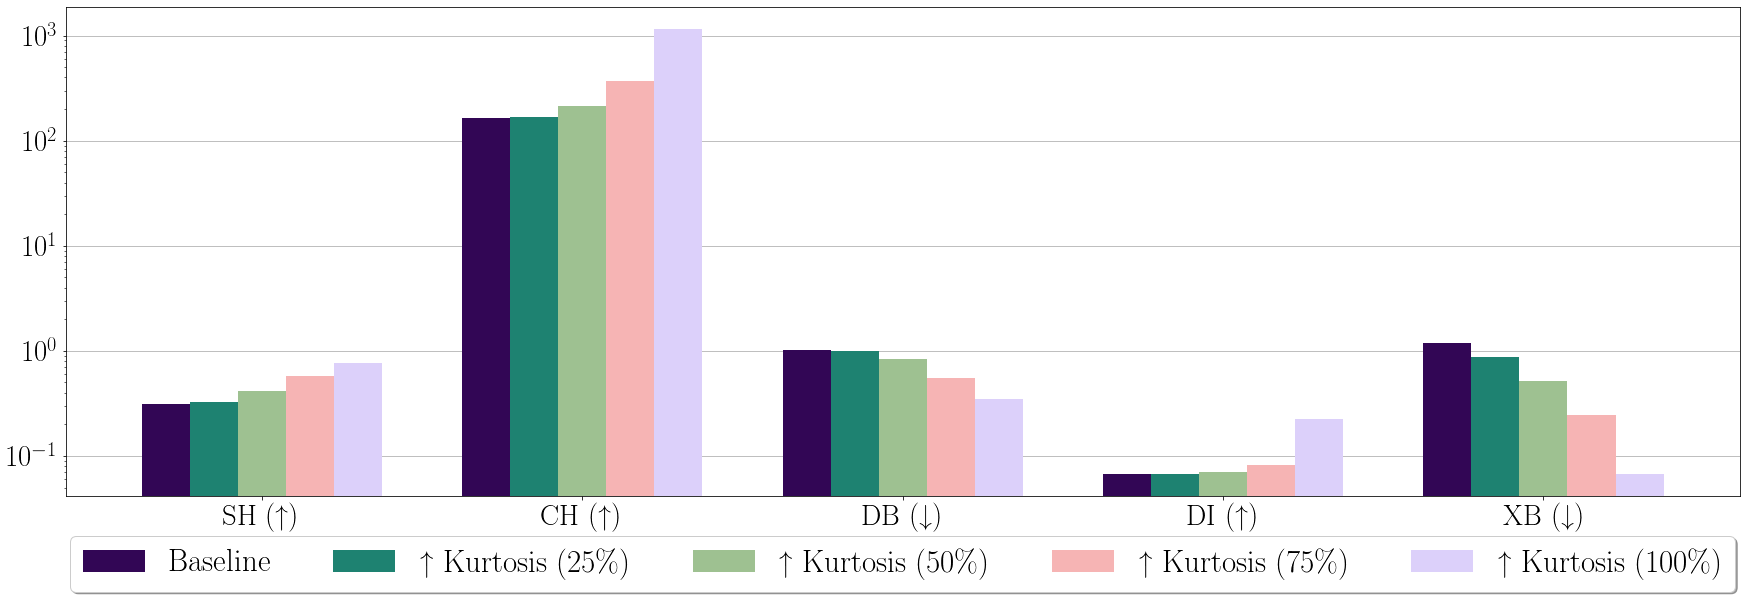

In [ ]:
'''
Plotting comparison for Kurtosis Results
'''
kurtosisScaled = False
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorKurtosisBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.figure(figsize=(30,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
ax = plt.axes()
ax.yaxis.grid(True)
ax.yaxis.set_zorder(0)
if not kurtosisScaled:
    ax.bar(index, cviScoresBLfin, width=bar_width, color=colorKurtosisBars[0], log=True, label='Baseline', zorder=3)
else:
    kurtosisCVIscoresALL = cviScoresBLfin
for i in range(len(kurtosisPercentIncrease)):
    if kurtosisScaled:
        kurtosisCVIscoresALL = np.vstack((kurtosisCVIscoresALL, kurtosisCVIscores[i]))
    else:
        ax.bar(index+(bar_width*(i+1)), kurtosisCVIscores[i], width=bar_width, color=colorKurtosisBars[i+1],
               log=True, label='\u2191 Kurtosis ('+str(kurtosisPercentIncrease[i])+'\%)', zorder=3)
if kurtosisScaled:
    kurtosisScaler = MinMaxScaler()
    kurtosisScaler.fit(kurtosisCVIscoresALL)
    kurtosisCVIscoresScaled = kurtosisScaler.transform(kurtosisCVIscoresALL)
    print(kurtosisCVIscoresScaled)
    ax.bar(index, kurtosisCVIscoresScaled[0]+0.1, width=bar_width, color=colorKurtosisBars[0], log=False, label='Baseline', zorder=3)
    for i in range(1,len(kurtosisCVIscoresScaled)):
        ax.bar(index+(bar_width*(i)), kurtosisCVIscoresScaled[i]+0.1, width=bar_width, color=colorKurtosisBars[i],
                log=False, label='\u2191 Kurtosis ('+str(kurtosisPercentIncrease[i-1])+'\%)', zorder=3)
ax.set_xticks(index + ((bar_width*len(kurtosisPercentIncrease))/ 2))
ax.set_xticklabels(cviLabels)
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

if kurtosisScaled:
    ax.set_ylim(bottom=0, top=1.1)
    #plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/kurtosis/incKurtosisBarGraphScaled.pdf',
    #            bbox_inches = 'tight', pad_inches = 0.05)
#else:
    #plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/kurtosis/incKurtosisBarGraph.pdf',
    #            bbox_inches = 'tight', pad_inches = 0.05)
#plt.close()

# **Change in Skewness**

Effect of change in skewness per cluster

1.   Increase Density using Multivariate Gaussian Distribution - only very near to the mean iff mean is far off the centroid
2.   Compute CVIs - Skewness 
3.   Check the increased skewness from tsne plot

In [31]:
######################################
'''
For data with clusters having 2 or more hoseholds only and non-overlapping
'''
######################################
start = time.time()

np.random.seed(seed=51)
skewnessPercentIncrease = [25, 50, 75, 100]
cviLabels = ['SH (\u2191)', 'CH (\u2191)', 'DB (\u2193)', 'DI (\u2191)', 'XB (\u2193)']
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
skewnessCVIscores = np.zeros((len(skewnessPercentIncrease), len(cviMetrics)))
TSNElegendLoc = ['lower left', 'lower right', 'lower right', 'lower right']
print(cviMetrics)
print(list(cviScoresBLfin), '\t- Baseline')
for exp in range(len(skewnessPercentIncrease)):
    nTrials = 100
    avgCVIscore = np.zeros((len(cviMetrics)))
    for k in range(nTrials):
        '''
        Fitting multivariate gaussian in each cluster
        '''
        nPercentPerCluster = skewnessPercentIncrease[exp]
        maxDistance = clusterRadiuses[i]/5
        newClusterList = deepcopy(clusterList)
        for i in range(nClustersBLfin):
            if euclidean_distances(clusterMeans[i].reshape(1,-1), clusterCenters[i].reshape(1,-1))[0,0] < clusterRadiuses[i]/3:
                continue
            # Work Around to Allow for HIGH Values of nPercentPerCluster
            nPtsPerCluster = min(max((int((clusterList[i].shape[0]*nPercentPerCluster)/100), 1)), len(clusterList[i])-len(farPoints[i]))
            newClusterList[i] = generate_synthetic_MVG(clusterList[i], clusterMeans[i], nPts=nPtsPerCluster, maxDist=maxDistance,
                                                       varFactor=4, maintainShape=True, fixedPts=farPoints[i])
        newData, newLabels = clusterList_to_dataNlabels(newClusterList)
        '''
        Calculating CVI scores
        '''
        cviScores = []
        for cviMetric in cviMetrics:
            _, metricScore = compute_cvi(newData, labelsMat=newLabels,
                                        cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                        #fuzzifier=fuzzifierPCA)
            cviScores.append(metricScore[0])
        avgCVIscore = ((avgCVIscore*(k+1))+np.array(cviScores))/(k+2)
    plot_TSNE(newData, newLabels, nClustersBLfin, randomSeed=51, perplexity=100, learning_rate=10, legend_loc=TSNElegendLoc[exp],#)
              figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/skewness/TSNE_skewness_'+
              str(skewnessPercentIncrease[exp])+'.pdf')
    skewnessCVIscores[exp] = avgCVIscore
    print(list(skewnessCVIscores[exp]), '\t-', skewnessPercentIncrease[exp], '%')
end = time.time()
print ("Time elapsed:", end - start, "seconds")

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.3132035301566134, 164.55220836188516, 1.02566140486872, 0.06765291933727599, 1.1964396370258807] 	- Baseline
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.001s...
[t-SNE] Computed neighbors for 302 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.073718


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.383148
[t-SNE] KL divergence after 750 iterations: 0.086658
[0.3564114594727693, 187.77898389981542, 0.9118128510427124, 0.06508191555941299, 1.0229768223225981] 	- 25 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.001s...
[t-SNE] Computed neighbors for 302 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.070082


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.473942
[t-SNE] KL divergence after 750 iterations: 0.079017
[0.4148655915892734, 221.7316981561321, 0.8037890907115299, 0.06576782282664531, 0.856983320977688] 	- 50 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.067945


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 150 iterations with early exaggeration: 41.652237
[t-SNE] KL divergence after 750 iterations: 0.061321
[0.48379946852301414, 272.8508319155033, 0.6978815897098744, 0.06989389703378401, 0.6943147711485288] 	- 75 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.001s...
[t-SNE] Computed neighbors for 302 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.063420


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.756908
[t-SNE] KL divergence after 750 iterations: 0.050882
[0.5534288641502865, 335.7790267405786, 0.6086666260682131, 0.08048997469167225, 0.5560194403195239] 	- 100 %
Time elapsed: 81.10431504249573 seconds


In [ ]:
'''
Plotting comparison for Skewness Results - Separate
'''
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorSkewnessBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rc('font', size=24)         # controls default text sizes
plt.rc('axes', titlesize=25)    # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)   # fontsize of the tick labels
plt.rc('ytick', labelsize=22)   # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=25)  # fontsize of the figure title
figure, axes = plt.subplots(1, len(cviLabels), figsize=(15,6), gridspec_kw={'width_ratios': [1]*len(cviLabels)})
figure.tight_layout(pad=0.5)

for i in range(len(cviLabels)):
    axes[i].yaxis.grid(True)
    axes[i].yaxis.set_zorder(0)
    axes[i].bar(0, cviScoresBLfin[i], width=bar_width, color=colorSkewnessBars[0], log=False, label='Baseline', zorder=3)
    tempScores = [cviScoresBLfin[i]]
    for j in range(len(skewnessPercentIncrease)):
        tempScores.append(skewnessCVIscores[j][i])
        axes[i].bar((bar_width*(j+1)), skewnessCVIscores[j][i], width=bar_width, color=colorSkewnessBars[j+1],
                    log=False, label='\u2191 Skewness ('+str(skewnessPercentIncrease[j])+'\%)', zorder=3)
    axes[i].set_ylim((0.9*min(tempScores), 1.05*max(tempScores)))
    axes[i].set_xticks([(bar_width*len(skewnessPercentIncrease))/ 2])
    axes[i].set_xticklabels([cviLabels[i]])
axes[0].set_ylabel("CVI Metric Value")
axes[0].legend(ncol=5, bbox_to_anchor=(-0.45, 0.675, 7, 0.5), loc='upper left', borderaxespad=0, mode="expand")#(0.625, 1.1)
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/skewness/incSkewnessBarGraph_Separate.pdf',
            bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

In [ ]:
'''
Plotting comparison for Skewness Results
'''
skewnessScaled = False
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorSkewnessBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.figure(figsize=(30,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
ax = plt.axes()
ax.yaxis.grid(True)
ax.yaxis.set_zorder(0)
if not skewnessScaled:
    ax.bar(index, cviScoresBLfin, width=bar_width, color=colorSkewnessBars[0], log=True, label='Baseline', zorder=3)
else:
    skewnessCVIscoresALL = cviScoresBLfin
for i in range(len(skewnessPercentIncrease)):
    if skewnessScaled:
        skewnessCVIscoresALL = np.vstack((skewnessCVIscoresALL, skewnessCVIscores[i]))
    else:
        ax.bar(index+(bar_width*(i+1)), skewnessCVIscores[i], width=bar_width, color=colorSkewnessBars[i+1],
               log=True, label='\u2191 Skewness ('+str(kurtosisPercentIncrease[i])+'\%)', zorder=3)
if skewnessScaled:
    skewnessScaler = MinMaxScaler()
    skewnessScaler.fit(skewnessCVIscoresALL)
    skewnessCVIscoresScaled = skewnessScaler.transform(skewnessCVIscoresALL)
    print(skewnessCVIscoresScaled)
    ax.bar(index, skewnessCVIscoresScaled[0]+0.1, width=bar_width, color=colorSkewnessBars[0], log=False, label='Baseline', zorder=3)
    for i in range(1,len(skewnessCVIscoresScaled)):
        ax.bar(index+(bar_width*(i)), skewnessCVIscoresScaled[i]+0.1, width=bar_width, color=colorSkewnessBars[i],
                log=False, label='\u2191 Skewness ('+str(skewnessPercentIncrease[i-1])+'\%)', zorder=3)
ax.set_xticks(index + ((bar_width*len(skewnessPercentIncrease))/ 2))
ax.set_xticklabels(cviLabels)
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

if skewnessScaled:
    ax.set_ylim(bottom=0, top=1.1)
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/skewness/incSkewnessBarGraphScaled.pdf',
                bbox_inches = 'tight', pad_inches = 0.05)
else:
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/skewness/incSkewnessBarGraph.pdf',
                bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

# **Change in Density**

Effect of differential density

Here, $\textrm{Density of the cluster} = \frac{\textrm{Number of points in the cluster}}{\textrm{Diameter of the cluster}}$

1.   Increase Density using Multivariate Gaussian Distribution near to the centroid in the cluster with maximum density
2.   Check the increased density from tsne plot
3.   Compute CVIs - Density   

In [29]:
######################################
'''
For data with clusters having 2 or more hoseholds only and non-overlapping
'''
######################################
start = time.time()

# Calculate initial density of the clusters
clusterDensity = np.zeros(nClustersBLfin)
for i in range(nClustersBLfin):
    clusterDensity[i] = clusterList[i].shape[0]/clusterDiameters[i]

maxD = np.argmax(clusterDensity)

cviLabels = ['SH (\u2191)', 'CH (\u2191)', 'DB (\u2193)', 'DI (\u2191)', 'XB (\u2193)']
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
TSNElegendLoc = ['upper right', 'lower left', 'lower right', 'lower right']

densityPercentIncrease = [25, 50, 75, 100]
maxDistance = clusterRadiuses[maxD]/5

print(cviMetrics)
print(list(cviScoresBLfin), '\t- Baseline')

densityCVIscores = np.zeros((len(densityPercentIncrease), len(cviMetrics)))
for exp in range(len(densityPercentIncrease)):
    nTrials = 100
    avgCVIscore = np.zeros((len(cviMetrics)))
    for k in range(nTrials):
        newClusterList = deepcopy(clusterList)
        np.random.seed(seed=51)
        newClusterList[maxD] = generate_synthetic_MVG(clusterList[maxD], clusterCenters[maxD], nPercent=densityPercentIncrease[exp], maxDist=maxDistance, varFactor=4)
        newData, newLabels = clusterList_to_dataNlabels(newClusterList)

        cviScores = []
        for cviMetric in cviMetrics:
            _, metricScore = compute_cvi(newData, labelsMat=newLabels,
                                        cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                        #fuzzifier=fuzzifierPCA)
            cviScores.append(metricScore[0])
        avgCVIscore = ((avgCVIscore*(k+1))+np.array(cviScores))/(k+2)
    plot_TSNE(newData, newLabels, nClustersBLfin, randomSeed=51, perplexity=100, learning_rate=10, legend_loc=TSNElegendLoc[exp],#)
              figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/density/TSNE_density_'+
              str(densityPercentIncrease[exp])+'.pdf')
    densityCVIscores[exp] = avgCVIscore
    print(list(densityCVIscores[exp]), '\t-', densityPercentIncrease[exp], '%')

end = time.time()
print ("Time elapsed:", end - start, "seconds")

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.3132035301566134, 164.55220836188516, 1.02566140486872, 0.06765291933727599, 1.1964396370258807] 	- Baseline
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 323 samples in 0.000s...
[t-SNE] Computed neighbors for 323 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 323 / 323
[t-SNE] Mean sigma: 0.072548


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 42.183262


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


[t-SNE] KL divergence after 700 iterations: 0.112094
[0.3248345246830043, 177.63483569575243, 0.9852138099820197, 0.06698308845274856, 0.9653345081158616] 	- 25 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 345 samples in 0.000s...
[t-SNE] Computed neighbors for 345 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 345 / 345
[t-SNE] Mean sigma: 0.068170


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 42.963234
[t-SNE] KL divergence after 700 iterations: 0.123692
[0.3441760235268244, 194.26364898962711, 0.9547292528650803, 0.06698308845274856, 0.8212421267328277] 	- 50 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 367 samples in 0.000s...
[t-SNE] Computed neighbors for 367 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 367 / 367
[t-SNE] Mean sigma: 0.063436


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 43.835217
[t-SNE] KL divergence after 750 iterations: 0.140692
[0.36436882719659336, 211.58901730848336, 0.9274177302865675, 0.06698308845274856, 0.717389594322915] 	- 75 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 389 samples in 0.000s...
[t-SNE] Computed neighbors for 389 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 389 / 389
[t-SNE] Mean sigma: 0.056741


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 200 iterations with early exaggeration: 44.457603
[t-SNE] KL divergence after 750 iterations: 0.147868
[0.3843067321671533, 229.24529199400044, 0.904698534830047, 0.06698308845274856, 0.6418893472078229] 	- 100 %
Time elapsed: 34.375715017318726 seconds


In [ ]:
'''
Plotting comparison for Density Results - Separate
'''
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorDensityBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rc('font', size=24)         # controls default text sizes
plt.rc('axes', titlesize=25)    # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)   # fontsize of the tick labels
plt.rc('ytick', labelsize=22)   # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=25)  # fontsize of the figure title
figure, axes = plt.subplots(1, len(cviLabels), figsize=(15,6), gridspec_kw={'width_ratios': [1]*len(cviLabels)})
figure.tight_layout(pad=0.5)

for i in range(len(cviLabels)):
    axes[i].yaxis.grid(True)
    axes[i].yaxis.set_zorder(0)
    axes[i].bar(0, cviScoresBLfin[i], width=bar_width, color=colorDensityBars[0], log=False, label='Baseline', zorder=3)
    tempScores = [cviScoresBLfin[i]]
    for j in range(len(densityPercentIncrease)):
        tempScores.append(densityCVIscores[j][i])
        axes[i].bar((bar_width*(j+1)), densityCVIscores[j][i], width=bar_width, color=colorDensityBars[j+1],
                    log=False, label='\u2191 Density ('+str(densityPercentIncrease[j])+'\%)', zorder=3)
    axes[i].set_ylim((0.9*min(tempScores), 1.05*max(tempScores)))
    axes[i].set_xticks([(bar_width*len(densityPercentIncrease))/ 2])
    axes[i].set_xticklabels([cviLabels[i]])
axes[0].set_ylabel("CVI Metric Value")
axes[0].legend(ncol=5, bbox_to_anchor=(-0.45, 0.675, 7, 0.5), loc='upper left', borderaxespad=0, mode="expand")#(0.625, 1.1)
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/density/incDensityBarGraph_Separate.pdf',
            bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

In [ ]:
'''
Plotting comparison for Density Results
'''
densityScaled = True
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorDensityBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#5b604c', '#939d7b', '#a8d0b5', '#efa3a3', '#80adcc'] - Inverted Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.figure(figsize=(30,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
ax = plt.axes()
ax.yaxis.grid(True)
ax.yaxis.set_zorder(0)
if not densityScaled:
    ax.bar(index, cviScoresBLfin, width=bar_width, color=colorDensityBars[0], log=True, label='Baseline', zorder=3)
else:
    densityCVIscoresALL = cviScoresBLfin
for i in range(len(densityPercentIncrease)):
    if densityScaled:
        densityCVIscoresALL = np.vstack((densityCVIscoresALL, densityCVIscores[i]))
    else:
        ax.bar(index+(bar_width*(i+1)), densityCVIscores[i], width=bar_width, color=colorDensityBars[i+1],
               log=True, label='\u2191 Density ('+str(kurtosisPercentIncrease[i])+'\%)', zorder=3)
if densityScaled:
    densityScaler = MinMaxScaler()
    densityScaler.fit(densityCVIscoresALL)
    densityCVIscoresScaled = densityScaler.transform(densityCVIscoresALL)
    print(densityCVIscoresScaled)
    ax.bar(index, densityCVIscoresScaled[0]+0.1, width=bar_width, color=colorDensityBars[0], log=False, label='Baseline', zorder=3)
    for i in range(1,len(densityCVIscoresScaled)):
        ax.bar(index+(bar_width*(i)), densityCVIscoresScaled[i]+0.1, width=bar_width, color=colorDensityBars[i],
                log=False, label='\u2191 Density ('+str(densityPercentIncrease[i-1])+'\%)', zorder=3)
ax.set_xticks(index + ((bar_width*len(densityPercentIncrease))/ 2))
ax.set_xticklabels(cviLabels)
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

if densityScaled:
    ax.set_ylim(bottom=0, top=1.1)
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/density/incDensityBarGraphScaled.pdf',
                bbox_inches = 'tight', pad_inches = 0.05)
else:
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/density/incDensityBarGraph.pdf',
                bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

[[0.         0.         1.         1.         1.        ]
 [0.16357905 0.20222606 0.66561975 0.         0.58325668]
 [0.43559914 0.45926765 0.41360393 0.         0.32342023]
 [0.71959202 0.72707632 0.18781958 0.         0.1361468 ]
 [1.         1.         0.         0.         0.        ]]


# **Sub-Clustering**

Effect of introducing sub-clustering in 1 of the clusters

1.   Increase Density using Multivariate Gaussian Distribution near to the centroid and mean of the cluster with maximum Euclidean distance between the 2
2.   Check the sub-clustering from tsne plot
3.   Compute CVIs - Sub-Clustering   

In [32]:
######################################
'''
For data with clusters having 2 or more hoseholds only and non-overlapping
'''
######################################
start = time.time()

# Calculate Euclidean distance between Mean and Centroid of each cluster
clusterMCdist = np.zeros(nClustersBLfin)
for i in range(nClustersBLfin):
    clusterMCdist[i] = euclidean_distances(clusterMeans[i,:].reshape(1,-1), clusterCenters[i,:].reshape(1,-1))[0,0]

maxSC = np.argmax(clusterMCdist)

cviLabels = ['SH (\u2191)', 'CH (\u2191)', 'DB (\u2193)', 'DI (\u2191)', 'XB (\u2193)']
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
TSNElegendLoc = ['upper right']

# [Centroid, Mean]
subClustering_nPercent = 50
maxDistanceSC = max(clusterMCdist)/3

print(cviMetrics)
print(list(cviScoresBLfin), '\t- Baseline')

subClusteringCVIscores = np.zeros((1, len(cviMetrics)))

nTrials = 100
avgCVIscore = np.zeros((len(cviMetrics)))
for k in range(nTrials):
    newClusterList = deepcopy(clusterList)
    np.random.seed(seed=51)
    nPtsCenter = int(((clusterList[maxSC].shape[0]-len(farPoints[maxSC]))*subClustering_nPercent)/100)
    nPtsMean = int(clusterList[maxSC].shape[0] - len(farPoints[maxSC]) - nPtsCenter)
    newClusterList[maxSC] = generate_synthetic_MVG(clusterList[maxSC], clusterCenters[maxSC], nPts=nPtsCenter, maxDist=maxDistanceSC,
                                                   varFactor=9, maintainShape=True, fixedPts=farPoints[maxSC])
    newClusterList[maxSC] = generate_synthetic_MVG(newClusterList[maxSC], clusterMeans[maxSC], nPts=nPtsMean, maxDist=maxDistanceSC,
                                                   varFactor=9, maintainShape=True, fixedPts=np.vstack((farPoints[maxSC], newClusterList[maxSC][-nPtsCenter:])))
    newData, newLabels = clusterList_to_dataNlabels(newClusterList)

    cviScores = []
    for cviMetric in cviMetrics:
        _, metricScore = compute_cvi(newData, labelsMat=newLabels,
                                    cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                    #fuzzifier=fuzzifierPCA)
        cviScores.append(metricScore[0])
    avgCVIscore = ((avgCVIscore*(k+1))+np.array(cviScores))/(k+2)
plot_TSNE(newData, newLabels, nClustersBLfin, randomSeed=51, perplexity=100, learning_rate=10, legend_loc=TSNElegendLoc[0],#)
            figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/subClustering/TSNE_subClustering.pdf')
subClusteringCVIscores[0] = avgCVIscore
print(list(subClusteringCVIscores[0]), '\t- Sub-Clustering')

end = time.time()
print ("Time elapsed:", end - start, "seconds")

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.3132035301566134, 164.55220836188516, 1.02566140486872, 0.06765291933727599, 1.1964396370258807] 	- Baseline
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.001s...
[t-SNE] Computed neighbors for 302 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.079258


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 40.039402
[t-SNE] KL divergence after 750 iterations: 0.078648
[0.35016740037726296, 231.8066471906145, 0.9496386598470787, 0.06698308845274856, 1.1363879583456375] 	- Sub-Clustering
Time elapsed: 7.927354097366333 seconds


In [ ]:
'''
Plotting comparison for Sub-Clustering Results - Separate
'''
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorSubClusteringBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rc('font', size=24)         # controls default text sizes
plt.rc('axes', titlesize=25)    # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)   # fontsize of the tick labels
plt.rc('ytick', labelsize=22)   # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=25)  # fontsize of the figure title
figure, axes = plt.subplots(1, len(cviLabels), figsize=(15,6), gridspec_kw={'width_ratios': [1]*len(cviLabels)})
figure.tight_layout(pad=0.5)

for i in range(len(cviLabels)):
    axes[i].yaxis.grid(True)
    axes[i].yaxis.set_zorder(0)
    axes[i].bar(0, cviScoresBLfin[i], width=bar_width, color=colorSubClusteringBars[1], log=False, label='Baseline', zorder=3)
    tempScores = [cviScoresBLfin[i]]
    for j in range(len(subClusteringCVIscores)):
        tempScores.append(subClusteringCVIscores[j][i])
        axes[i].bar((bar_width*(j+1)), subClusteringCVIscores[j][i], width=bar_width, color=colorSubClusteringBars[j+3],
                    log=False, label='Sub-Clustering', zorder=3)
    axes[i].set_ylim((0.9*min(tempScores), 1.05*max(tempScores)))
    axes[i].set_xticks([(bar_width*len(subClusteringCVIscores))/ 2])
    axes[i].set_xticklabels([cviLabels[i]])
axes[0].set_ylabel("CVI Metric Value")
axes[0].legend(ncol=2, bbox_to_anchor=(0.6, 0.675, 5, 0.5), loc='upper left', borderaxespad=0, mode="expand")#(0.625, 1.1)
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/subClustering/subClusteringBarGraph_Separate.pdf',
            bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

In [ ]:
'''
Plotting comparison for Sub-Clustering Results
'''
subClusteringScaled = False
index = np.arange(len(cviMetrics))
bar_width = 0.3
colorSubClusteringBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.figure(figsize=(30,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
ax = plt.axes()
ax.yaxis.grid(True)
ax.yaxis.set_zorder(0)
if not subClusteringScaled:
    ax.bar(index, cviScoresBLfin, width=bar_width, color=colorSubClusteringBars[1], log=True, label='Baseline', zorder=3)
else:
    subClusteringCVIscoresALL = cviScoresBLfin
for i in range(len(subClusteringCVIscores)):
    if subClusteringScaled:
        subClusteringCVIscoresALL = np.vstack((subClusteringCVIscoresALL, subClusteringCVIscores[i]))
    else:
        ax.bar(index+(bar_width*(i+1)), subClusteringCVIscores[i], width=bar_width, color=colorSubClusteringBars[i+3],
               log=True, label='Sub-Clustering', zorder=3)
if subClusteringScaled:
    subClusteringScaler = MinMaxScaler()
    subClusteringScaler.fit(subClusteringCVIscoresALL)
    subClusteringCVIscoresScaled = subClusteringScaler.transform(subClusteringCVIscoresALL)
    print(subClusteringCVIscoresScaled)
    ax.bar(index, subClusteringCVIscoresScaled[0]+0.1, width=bar_width, color=colorSubClusteringBars[1], log=False, label='Baseline', zorder=3)
    for i in range(1,len(subClusteringCVIscoresScaled)):
        ax.bar(index+(bar_width*(i)), subClusteringCVIscoresScaled[i]+0.1, width=bar_width, color=colorSubClusteringBars[i+2],
                log=False, label='Sub-Clustering', zorder=3)
ax.set_xticks(index + ((bar_width*len(subClusteringCVIscores))/ 2))
ax.set_xticklabels(cviLabels)
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
#ax.legend()

if subClusteringScaled:
    ax.set_ylim(bottom=0, top=1.1)
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/subClustering/subClusteringBarGraphScaled.pdf',
                bbox_inches = 'tight', pad_inches = 0.05)
else:
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/subClustering/subClusteringBarGraph.pdf',
                bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

# **Change in Diameter and Seperation**

Effect of reduction in diameter by 15%, 20%, 25%, and 30%

In [33]:
def removeFarPoints(clusterList, centerPoints, farDist):
    """
    Removes points that are too far from the cluster center.
    Params:
        clusterList: List [ndarray of shape (n_samples, n_features)] of length
                     n_Clusters
            - original clusters stored in a list
        centerPoints: List [ndarray of shape (n_features,)] of length n_Clusters
            - cluster centroids of the original clusters
        farDist: List [float] of length n_Clusters OR ndarray of shape (n_Clusters,)
            - the cut-off distance for each cluster, beyond which all the points
              must be removed from the cluster
    Returns:
        newClusterList: List [ndarray of shape (n_samples, n_features)] of length
                        n_Clusters
            - reduced clusters stored in a list
        nReducedPoints: List [int] of length n_Clusters
            - number of points that were removed from each cluster
    """
    n_Clusters = len(clusterList)
    newClusterList = []
    nReducedPoints = []
    for i in range(n_Clusters):
        nReduced = 0
        newCluster = deepcopy(clusterList[i])
        for j in range(clusterList[i].shape[0]):
            if euclidean_distances(clusterList[i][j,:].reshape(1,-1), centerPoints[i].reshape(1,-1))[0,0] > farDist[i] and nReduced<clusterList[i].shape[0]-2:
                newCluster = np.delete(newCluster, j-nReduced, axis=0)
                nReduced += 1
        newClusterList.append(newCluster)
        nReducedPoints.append(nReduced)
    return newClusterList, nReducedPoints

In [34]:
######################################
'''
For data with clusters having 2 or more hoseholds only (post outlier removal)
'''
######################################
start = time.time()

maxDist = np.zeros(clusterRadiuses.shape)
for i in range(len(clusterList)):
    maxDist[i] = max(euclidean_distances(clusterList[i], clusterCenters[i].reshape(1,-1)))[0]

cviLabels = ['SH (\u2191)', 'CH (\u2191)', 'DB (\u2193)', 'DI (\u2191)', 'XB (\u2193)']
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
TSNElegendLoc = ['upper right', 'lower right', 'lower right', 'lower right']

reductionFactor = [0.15, 0.2, 0.25, 0.3]
diameterCVIscores = np.zeros((len(reductionFactor), len(cviMetrics)))
for exp in range(len(reductionFactor)):
    reducedClusterList, nReducedPoints = removeFarPoints(clusterList, clusterCenters, maxDist*(1-reductionFactor[exp]))
    nTrials = 100
    avgCVIscore = np.zeros((len(cviMetrics)))
    for k in range(nTrials):
        newClusterList = deepcopy(reducedClusterList)
        for i in range(len(reducedClusterList)):
            newClusterList[i] = generate_synthetic_MVG(reducedClusterList[i], clusterCenters[i], nPts=nReducedPoints[i],
                                                    varFactor=4, maxDist=maxDist[i]*(1-reductionFactor[exp]))
        newData, newLabels = clusterList_to_dataNlabels(newClusterList)
        cviScores = []
        for cviMetric in cviMetrics:
            _, metricScore = compute_cvi(newData, labelsMat=newLabels,
                                        cvi_metric = cviMetric, dist_metric = 'euclidean')#,
                                        #fuzzifier=fuzzifierPCA)
            cviScores.append(metricScore[0])
        avgCVIscore = ((avgCVIscore*(k+1))+np.array(cviScores))/(k+2)
    plot_TSNE(newData, newLabels, nClustersBLfin, randomSeed=51, perplexity=100, learning_rate=10, legend_loc=TSNElegendLoc[exp],
              figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/diameter/TSNE_diameter_'+str(reductionFactor[exp]*100)+'.pdf')
    diameterCVIscores[exp] = avgCVIscore
    print(list(diameterCVIscores[exp]), '\t-', reductionFactor[exp]*100, '%')

end = time.time()
print ("Time elapsed:", end - start, "seconds")

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.001s...
[t-SNE] Computed neighbors for 302 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.085284


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.333862
[t-SNE] KL divergence after 750 iterations: 0.076540
[0.35747921901943286, 205.02562227029514, 0.9297391333642424, 0.06698308845274856, 0.8438328409471718] 	- 15.0 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.088632


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.616741
[t-SNE] KL divergence after 750 iterations: 0.068783
[0.3892395864628878, 231.8370544306297, 0.8725914002106017, 0.10496385017789812, 0.6693118344465251] 	- 20.0 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.000s...
[t-SNE] Computed neighbors for 302 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.093242


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 100 iterations with early exaggeration: 41.788071
[t-SNE] KL divergence after 750 iterations: 0.053395
[0.457822641543803, 293.9298943940989, 0.7242420165415183, 0.10639866951399628, 0.465139434661369] 	- 25.0 %
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 302 samples in 0.001s...
[t-SNE] Computed neighbors for 302 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 302 / 302
[t-SNE] Mean sigma: 0.099962


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 200 iterations with early exaggeration: 41.937504
[t-SNE] KL divergence after 750 iterations: 0.050137
[0.515898995499638, 366.24270222855665, 0.6323533162941178, 0.17665686329203886, 0.3205214486533891] 	- 30.0 %
Time elapsed: 24.432268381118774 seconds


In [ ]:
'''
Plotting comparison for Diameter Results - Separate
'''
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorDiameterBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['text.usetex'] = True
plt.rc('font', size=24)         # controls default text sizes
plt.rc('axes', titlesize=25)    # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)   # fontsize of the tick labels
plt.rc('ytick', labelsize=22)   # fontsize of the tick labels
plt.rc('legend', fontsize=22)   # legend fontsize
plt.rc('figure', titlesize=25)  # fontsize of the figure title
figure, axes = plt.subplots(1, len(cviLabels), figsize=(15,6), gridspec_kw={'width_ratios': [1]*len(cviLabels)})
figure.tight_layout(pad=0.5)

for i in range(len(cviLabels)):
    axes[i].yaxis.grid(True)
    axes[i].yaxis.set_zorder(0)
    axes[i].bar(0, cviScoresBLfin[i], width=bar_width, color=colorDiameterBars[0], log=False, label='Baseline', zorder=3)
    tempScores = [cviScoresBLfin[i]]
    for j in range(len(reductionFactor)):
        tempScores.append(diameterCVIscores[j][i])
        axes[i].bar((bar_width*(j+1)), diameterCVIscores[j][i], width=bar_width, color=colorDiameterBars[j+1],
                    log=False, label='\u2193 Diameter ('+str(int(reductionFactor[j]*100))+'\%)', zorder=3)
    axes[i].set_ylim((0.9*min(tempScores), 1.05*max(tempScores)))
    axes[i].set_xticks([(bar_width*len(reductionFactor))/ 2])
    axes[i].set_xticklabels([cviLabels[i]])
axes[0].set_ylabel("CVI Metric Value")
axes[0].legend(ncol=5, bbox_to_anchor=(-0.45, 0.675, 7, 0.5), loc='upper left', borderaxespad=0, mode="expand")#(0.625, 1.1)
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/diameter/incDiameterBarGraph_Separate.pdf',
            bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

In [ ]:
'''
Plotting comparison for Diameter Results
'''
diameterScaled = True
index = np.arange(len(cviMetrics))
bar_width = 0.15
colorDiameterBars = ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa']
# ['#80adcc', '#efa3a3', '#a8d0b5', '#939d7b', '#5b604c'] - Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#5b604c', '#939d7b', '#a8d0b5', '#efa3a3', '#80adcc'] - Inverted Wardrobe Nearly Neutrals Soft Autumn Color Palette
# ['#ffd966', '#f5972d', '#cfa45f', '#397c1b', '#2a4020'] - TVA Loki Palette Color Palette
# ['#281d1d', '#47596a', '#85a2a3', '#b7b4d2', '#d2dddf'] - neki Color Palette
# ['#f55252', '#cfe64f', '#7ae4ba', '#a670f2', '#e165e9'] - Candy Stall Color Palette
# ['#320655', '#1e8271', '#9ec191', '#f6b4b4', '#dcd0fa'] - Fairy Princess Magic Color Palette

plt.figure(figsize=(30,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
ax = plt.axes()
ax.yaxis.grid(True)
ax.yaxis.set_zorder(0)
if not diameterScaled:
    ax.bar(index, cviScoresBLfin, width=bar_width, color=colorDiameterBars[0], log=True, label='Baseline', zorder=3)
else:
    diameterCVIscoresALL = cviScoresBLfin
for i in range(len(reductionFactor)):
    if diameterScaled:
        diameterCVIscoresALL = np.vstack((diameterCVIscoresALL, diameterCVIscores[i]))
    else:
        ax.bar(index+(bar_width*(i+1)), diameterCVIscores[i], width=bar_width, color=colorDiameterBars[i+1],
               log=True, label='\u2193 Diameter ('+str(reductionFactor[i]*100)+'\%)', zorder=3)
if diameterScaled:
    diameterScaler = MinMaxScaler()
    diameterScaler.fit(diameterCVIscoresALL)
    diameterCVIscoresScaled = diameterScaler.transform(diameterCVIscoresALL)
    print(diameterCVIscoresScaled)
    ax.bar(index, diameterCVIscoresScaled[0]+0.1, width=bar_width, color=colorDiameterBars[0], log=False, label='Baseline', zorder=3)
    for i in range(1,len(densityCVIscoresScaled)):
        ax.bar(index+(bar_width*(i)), diameterCVIscoresScaled[i]+0.1, width=bar_width, color=colorDiameterBars[i],
                log=False, label='\u2193 Diameter ('+str(reductionFactor[i-1]*100)+'\%)', zorder=3)
ax.set_xticks(index + ((bar_width*len(reductionFactor))/ 2))
ax.set_xticklabels(cviLabels)
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

if diameterScaled:
    ax.set_ylim(bottom=0, top=1.1)
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/diameter/redDiameterBarGraphScaled.pdf',
                bbox_inches = 'tight', pad_inches = 0.05)
else:
    plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis Extension/results/diameter/redDiameterBarGraph.pdf',
                bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

[[0.         0.         1.         0.00610748 1.        ]
 [0.21843453 0.2006709  0.75611417 0.         0.59744323]
 [0.3751246  0.33360445 0.61081399 0.34630669 0.39819973]
 [0.71347976 0.64146645 0.23363033 0.3593893  0.16510444]
 [1.         1.         0.         1.         0.        ]]
